# Agglomerative Clustering

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sns
from itertools import permutations
from scipy.stats import uniform, normaltest
from sklearn import svm, neighbors, tree
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.preprocessing import normalize, PowerTransformer, OneHotEncoder, OrdinalEncoder, Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import rand_score,adjusted_mutual_info_score

## Importing Data and Pre-processing

In [2]:
# Import Data
data = pd.read_csv('data.txt',index_col=0)
pd.set_option('display.max_columns', 12)
data.head(7)

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5,Contains_Crack,Position_of_Crack
0,163.770,1.043534,1.043524,0.000001,1.043544,1.043534,...,0.053607,0.000155,0.053609,0.053611,No,No Crack
1,161.168,1.043284,1.038036,0.094323,1.031535,1.092445,...,0.069334,0.086817,0.460091,0.254838,Yes,Top Right
2,164.121,1.146271,1.026070,0.055705,1.013540,1.031031,...,0.391759,0.011229,0.163528,0.319310,Yes,Top Left
3,162.045,1.042523,1.045912,0.044661,1.056414,1.046251,...,0.053956,0.022008,0.054064,0.054362,Yes,Bottom Left
4,163.042,1.040145,1.030799,0.015596,1.043248,1.064751,...,0.053708,0.016016,0.057733,0.101230,Yes,Bottom Right
5,163.770,1.043534,1.043524,0.000001,1.043544,1.043534,...,0.053607,0.000155,0.053609,0.053611,No,No Crack
6,159.572,1.047045,1.027146,0.083370,1.042486,1.054308,...,0.146392,0.110386,0.068477,0.118288,Yes,Top Right


In [3]:
# Adding Noise
np.random.seed(1)
for col in data:
    if col != 'Contains_Crack' and col != 'Position_of_Crack':
        std_TR = np.std(data.loc[data['Position_of_Crack'] == 'Top Right', col])
        std_TL = np.std(data.loc[data['Position_of_Crack'] == 'Top Left', col])
        std_BL = np.std(data.loc[data['Position_of_Crack'] == 'Bottom Left', col])
        std_BR = np.std(data.loc[data['Position_of_Crack'] == 'Bottom Right', col])
        std_avg = (std_TR+std_TL+std_BL+std_BR)/4
    
        noise = np.random.uniform(-std_avg,std_avg,len(data[col]))
        data[col] = data[col] + noise
data.shape

(100, 56)

In [4]:
# Remove the target from the dataset
data.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1 = data.Contains_Crack
y2 = data.Position_of_Crack
data.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)
data

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,163.516307,1.038170,1.068703,0.021232,1.062176,0.830729,...,838.715944,0.142866,0.098044,0.036677,0.128474,0.030246
1,161.841610,1.044121,1.041205,0.119850,1.043862,0.951773,...,822.922837,0.565163,0.135012,0.129534,0.459730,0.288985
2,162.592673,1.158212,1.049316,0.068532,0.994574,0.935274,...,825.845806,0.053755,0.275476,0.058117,0.141599,0.425193
3,161.440661,1.038107,1.053830,0.049393,1.064906,0.878473,...,838.426601,0.120835,0.173844,-0.024460,0.083506,0.037301
4,161.962008,1.052786,1.024647,-0.007485,1.041829,1.119997,...,835.374843,0.085093,-0.047885,0.068026,0.031878,0.102733
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,162.965998,1.056900,1.019373,0.023410,1.061058,0.888231,...,843.224625,-0.005461,-0.050806,0.051564,0.064393,-0.022629
96,160.879274,1.022117,1.119511,0.082316,1.057186,0.832265,...,827.146286,0.127383,0.116638,0.248995,0.304281,0.077025
97,162.440264,1.028118,1.011183,0.019398,1.055071,0.977400,...,828.464281,0.000394,0.245330,0.056035,0.243257,0.208921
98,163.178099,1.018555,1.058280,0.050581,1.157652,0.794373,...,835.827020,0.500143,0.284131,0.042238,0.096635,0.045737


In [5]:
# Encoding targets
for idx in range(len(y1)):
    if y1[idx] == 'Yes':
        y1[idx] = int(1)
    elif y1[idx] == 'No': 
        y1[idx] = int(0)
    
    if y2[idx] == 'No Crack':
        y2[idx] = int(0)
    elif y2[idx] == 'Top Right':
        y2[idx] = int(1)
    elif y2[idx] == 'Top Left':
        y2[idx] = int(2)
    elif y2[idx] == 'Bottom Left':
        y2[idx] = int(3)
    elif y2[idx] == 'Bottom Right':
        y2[idx] = int(4)
y1 = y1.to_numpy(dtype=int)
y2 = y2.to_numpy(dtype=int)

In [6]:
# Split the data into feature sets
X1 = data
X2 = data[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3 = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

In [7]:
# Mean Center the data
for col in X1:
    X1.loc[:,col] = X1.loc[:,col] - X1.loc[:,col].mean()

for col in X2:
    X2.loc[:,col] = X2.loc[:,col] - X2.loc[:,col].mean()
    
for col in X3:
    X3.loc[:,col] = X3.loc[:,col] - X3.loc[:,col].mean()

X1

C:\Users\James\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,1.162363,-0.006972,0.016339,-0.013802,0.014803,-0.316782,...,4.706269,-0.019932,-0.030164,-0.043621,-0.023595,-0.121468
1,-0.512334,-0.001021,-0.011159,0.084816,-0.003511,-0.195739,...,-11.086838,0.402364,0.006804,0.049236,0.307661,0.137271
2,0.238729,0.113070,-0.003048,0.033497,-0.052800,-0.212238,...,-8.163870,-0.109044,0.147268,-0.022181,-0.010470,0.273479
3,-0.913283,-0.007036,0.001466,0.014358,0.017532,-0.269038,...,4.416925,-0.041963,0.045636,-0.104757,-0.068563,-0.114413
4,-0.391936,0.007643,-0.027717,-0.042520,-0.005545,-0.027514,...,1.365167,-0.077706,-0.176092,-0.012272,-0.120191,-0.048981
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.612055,0.011757,-0.032991,-0.011625,0.013685,-0.259281,...,9.214949,-0.168260,-0.179014,-0.028734,-0.087676,-0.174343
96,-1.474670,-0.023026,0.067147,0.047281,0.009813,-0.315247,...,-6.863389,-0.035416,-0.011570,0.168697,0.152212,-0.074689
97,0.086320,-0.017025,-0.041182,-0.015637,0.007698,-0.170112,...,-5.545395,-0.162404,0.117123,-0.024263,0.091189,0.057207
98,0.824155,-0.026587,0.005916,0.015547,0.110279,-0.353139,...,1.817344,0.337344,0.155924,-0.038060,-0.055434,-0.105977


## No Scaling

In [20]:
# Situation 1
# x1 y1
x1y1_KM = KMeans(n_clusters=2, random_state=0)
x1y1_KM.fit(X1)

x1y1_predict = x1y1_KM.labels_
x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
x1y1_f1_score = f1_score(y1,x1y1_predict)
x1y1_NMI_score = adjusted_mutual_info_score(y1,x1y1_predict) 

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and NMI score of:",x1y1_NMI_score,"\n")

# x2 y1
x2y1_KM = KMeans(n_clusters=2, random_state=0)
x2y1_KM.fit(X2, y1)

x2y1_predict = x2y1_KM.labels_
x2y1_accuracy_score = accuracy_score(y1,x2y1_predict)
x2y1_f1_score = f1_score(y1,x2y1_predict)
x2y1_NMI_score = adjusted_mutual_info_score(y1,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and NMI score of:",x2y1_NMI_score,"\n")

# x3 y1
x3y1_KM = KMeans(n_clusters=2, random_state=0)
x3y1_KM.fit(X3, y1)

x3y1_predict = x3y1_KM.labels_
x3y1_accuracy_score = accuracy_score(y1,x3y1_predict)
x3y1_f1_score = f1_score(y1,x3y1_predict)
x3y1_NMI_score = adjusted_mutual_info_score(y1,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and NMI score of:",x3y1_NMI_score,"\n")

Predicted values using x1 and y1: [1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1
 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0
 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.27 and f1 score of: 0.4251968503937008 and NMI score of: 0.2957601882485634 

Predicted values using x2 and y1: [1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1
 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0
 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 

In [21]:
for idx in range(len(x1y1_predict)):
    if x1y1_predict[idx] == 0:
        x1y1_predict[idx] = 1
    elif x1y1_predict[idx] == 1:
        x1y1_predict[idx] = 0
            
x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
x1y1_f1_score = f1_score(y1,x1y1_predict)
x1y1_NMI_score = adjusted_mutual_info_score(y1,x1y1_predict) 

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and NMI score of:",x1y1_NMI_score,"\n")

for idx in range(len(x2y1_predict)):
    if x2y1_predict[idx] == 0:
        x2y1_predict[idx] = 1
    elif x2y1_predict[idx] == 1:
        x2y1_predict[idx] = 0
        
x2y1_accuracy_score = accuracy_score(y1,x2y1_predict)
x2y1_f1_score = f1_score(y1,x2y1_predict)
x2y1_NMI_score = adjusted_mutual_info_score(y1,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and NMI score of:",x2y1_NMI_score,"\n")

for idx in range(len(x3y1_predict)):
    if x3y1_predict[idx] == 0:
        x3y1_predict[idx] = 1
    elif x3y1_predict[idx] == 1:
        x3y1_predict[idx] = 0
        
x3y1_accuracy_score = accuracy_score(y1,x3y1_predict)
x3y1_f1_score = f1_score(y1,x3y1_predict)
x3y1_NMI_score = adjusted_mutual_info_score(y1,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and NMI score of:",x3y1_NMI_score,"\n")

Predicted values using x1 and y1: [0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1
 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.73 and f1 score of: 0.7969924812030075 and NMI score of: 0.2957601882485634 

Predicted values using x2 and y1: [0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1
 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 

In [9]:
# Situation 2
# x1 y2
x1y2_KM = KMeans(n_clusters=5, random_state=0)
x1y2_KM.fit(X1)

x1y2_predict = x1y2_KM.labels_
x1y2_accuracy_score = accuracy_score(y2,x1y2_predict)
x1y2_f1_score = f1_score(y2,x1y2_predict,average='macro')
x1y2_NMI_score = adjusted_mutual_info_score(y2,x1y2_predict) 

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and NMI score of:",x1y2_NMI_score,"\n")

# x2 y2
x2y2_KM = KMeans(n_clusters=5, random_state=0)
x2y2_KM.fit(X2)

x2y2_predict = x2y2_KM.labels_
x2y2_accuracy_score = accuracy_score(y2,x2y2_predict)
x2y2_f1_score = f1_score(y2,x2y2_predict,average='macro')
x2y2_NMI_score = adjusted_mutual_info_score(y2,x2y2_predict) 
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and NMI score of:",x2y2_NMI_score,"\n")

# x3 y2
x3y2_KM = KMeans(n_clusters=5, random_state=0)
x3y2_KM.fit(X3)

x3y2_predict = x3y2_KM.labels_
x3y2_accuracy_score = accuracy_score(y2,x3y2_predict)
x3y2_f1_score = f1_score(y2,x3y2_predict,average='macro')
x3y2_NMI_score = adjusted_mutual_info_score(y2,x3y2_predict) 

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and NMI score of:",x3y2_NMI_score,"\n")

Predicted values using x1 and y2: [1 3 2 0 1 1 4 3 1 2 1 3 0 4 4 1 2 4 3 3 0 2 2 2 2 1 2 2 4 0 1 2 0 2 2 1 4
 2 1 4 1 0 0 2 4 1 0 1 0 2 0 0 4 2 4 1 2 4 0 4 1 0 3 4 3 1 2 4 4 4 0 3 4 3
 2 1 1 2 2 4 1 0 3 0 2 1 0 4 2 2 1 2 2 2 1 1 2 0 0 4]
Expected values: [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3
 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]
Resulting in an accuracy score of: 0.2 and f1 score of: 0.1967382230172928 and NMI score of: 0.1651653047201322 

Predicted values using x2 and y2: [1 2 4 0 1 1 3 2 1 4 1 2 0 3 3 1 4 3 2 2 0 4 4 4 4 1 4 4 3 4 1 4 0 4 4 1 3
 4 1 3 1 0 0 4 3 1 0 1 0 4 0 0 3 4 3 1 4 3 0 3 1 0 2 3 2 1 4 3 3 3 0 2 3 2
 4 1 1 4 4 3 1 0 2 0 4 1 0 3 4 4 1 4 4 4 1 1 4 0 0 3]
Expected values: [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3
 4 0 1 2 3 4 0 1 2 3 4

C:\Users\James\AppData\Local\Temp/ipykernel_19944/2460818383.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(linkages,size=20)
C:\Users\James\AppData\Local\Temp/ipykernel_19944/2460818383.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(affinities,size=20)


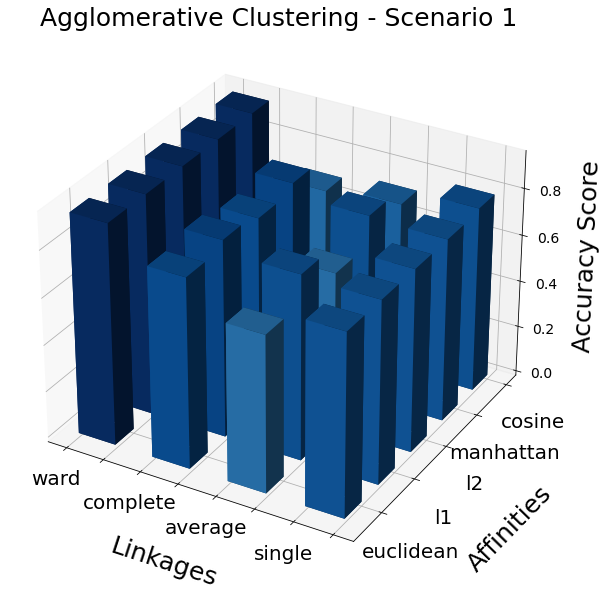

[[0.94 0.94 0.94 0.94 0.94]
 [0.81 0.84 0.81 0.84 0.69]
 [0.67 0.79 0.67 0.79 0.72]
 [0.78 0.78 0.78 0.78 0.79]]


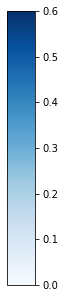

In [16]:
linkages = ['ward','complete','average','single']
affinities = ['euclidean','l1','l2','manhattan','cosine']
scores = np.ones([len(linkages),len(affinities)])

numOfCols = len(linkages)
numOfRows = len(affinities)

for i in range(len(linkages)):
    for j in range(len(affinities)):
        if linkages[i] == 'ward':
            x1y1_AC = AgglomerativeClustering(n_clusters=2,linkage='ward',affinity='euclidean')
        else:
            x1y1_AC = AgglomerativeClustering(n_clusters=2,linkage=linkages[i],affinity=affinities[j])
        x1y1_AC.fit(X2, y1)

        x1y1_predict = x1y1_AC.labels_
        x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
        if x1y1_accuracy_score < 0.5:
            x1y1_accuracy_score = 1 - x1y1_accuracy_score
        scores[i,j] = x1y1_accuracy_score
        
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = scores.flatten(order='F')

linkages = ['','ward','','complete','','average','','single']
affinities = ['','euclidean','l1','l2','manhattan','cosine']

colors = plt.cm.Blues(scores.flatten(order='F')/float(scores.max()))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = "3d")
bar = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
ax.tick_params(axis='x', which='major', pad=8)
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xticklabels(linkages,size=20)
ax.set_yticklabels(affinities,size=20)
ax.zaxis.set_tick_params(labelsize=14, pad=8)

ax.set_xlabel('Linkages',size=25, labelpad=30)
ax.set_ylabel('Affinities',size=25, labelpad=45)
ax.set_zlabel('Accuracy Score',size=25, labelpad=20)
ax.set_title('Agglomerative Clustering - Scenario 1',size=25)
plt.show()

fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical')

print(scores)

C:\Users\James\AppData\Local\Temp/ipykernel_26924/4034245087.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(linkages,size=20)
C:\Users\James\AppData\Local\Temp/ipykernel_26924/4034245087.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(affinities,size=20)


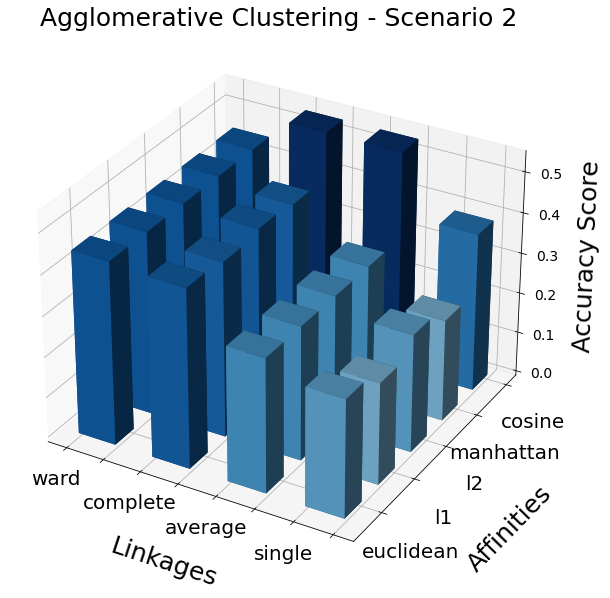

[[0.45 0.45 0.45 0.45 0.45]
 [0.44 0.43 0.44 0.43 0.54]
 [0.33 0.33 0.33 0.33 0.54]
 [0.29 0.25 0.29 0.25 0.39]]


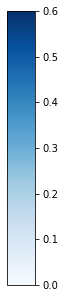

In [12]:
linkages = ['ward','complete','average','single']
affinities = ['euclidean','l1','l2','manhattan','cosine']
scores = np.ones([len(linkages),len(affinities)])

numOfCols = len(linkages)
numOfRows = len(affinities)

for i in range(len(linkages)):
    for j in range(len(affinities)):
        if linkages[i] == 'ward':
            x1y1_AC = AgglomerativeClustering(n_clusters=5,linkage='ward',affinity='euclidean')
        else:
            x1y1_AC = AgglomerativeClustering(n_clusters=5,linkage=linkages[i],affinity=affinities[j])
        x1y1_AC.fit(X3)
        x1y1_predict = x1y1_AC.labels_
        
        arr = np.ones(len(x1y1_predict),dtype='int32')
        best_acc = 0
        best_f1 = 0
        best_NMI = 0

        combs = []
        arrs = np.array([0,1,2,3,4],dtype='int32')
        for comb in permutations(arrs):
            combs.append(comb)
        combs = np.array(combs)

        for combi in combs:
            for idx in range(len(x1y1_predict)):
                val = x1y1_predict[idx]
                if val == 0:
                    arr[idx] = combi[0]
                if val == 1:
                    arr[idx] = combi[1]
                if val == 2:
                    arr[idx] = combi[2]
                if val == 3:
                    arr[idx] = combi[3]
                if val == 4:
                    arr[idx] = combi[4]
            accuracy_scorei = accuracy_score(y2,arr)
            if accuracy_scorei > best_acc:
                best_acc = accuracy_scorei
                f1_scorei = f1_score(y2,arr,average='macro')
                best_f1 = f1_scorei
                NMI_score = adjusted_mutual_info_score(y2,arr)
                best_NMI = NMI_score
                best_arr = arr

        scores[i,j] = best_acc
        
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = scores.flatten(order='F')

linkages = ['','ward','','complete','','average','','single']
affinities = ['','euclidean','l1','l2','manhattan','cosine']

colors = plt.cm.Blues(scores.flatten(order='F')/float(scores.max()))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = "3d")
bar = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
ax.tick_params(axis='x', which='major', pad=8)
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xticklabels(linkages,size=20)
ax.set_yticklabels(affinities,size=20)
ax.zaxis.set_tick_params(labelsize=14, pad=8)

ax.set_xlabel('Linkages',size=25, labelpad=30)
ax.set_ylabel('Affinities',size=25, labelpad=45)
ax.set_zlabel('Accuracy Score',size=25, labelpad=20)
ax.set_title('Agglomerative Clustering - Scenario 2',size=25)
plt.show()

fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical')

print(scores)

## Normalisation

In [13]:
# Normalize the data
normalizer = Normalizer('l2')
X1_norm = pd.DataFrame(normalizer.fit_transform(X1))
  
normalizer = Normalizer('l2')
X2_norm = pd.DataFrame(normalizer.fit_transform(X2))

normalizer = Normalizer('l2')
X3_norm = pd.DataFrame(normalizer.fit_transform(X3))

X1_norm

,0,1,2,3,4,5,...,48,49,50,51,52,53
0,0.027235,-0.000163,0.000383,-0.000323,0.000347,-0.007422,...,0.110270,-0.000467,-0.000707,-0.001022,-0.000553,-0.002846
1,-0.013189,-0.000026,-0.000287,0.002183,-0.000090,-0.005039,...,-0.285412,0.010358,0.000175,0.001268,0.007920,0.003534
2,0.007638,0.003617,-0.000098,0.001072,-0.001689,-0.006790,...,-0.261187,-0.003489,0.004712,-0.000710,-0.000335,0.008749
3,-0.042777,-0.000330,0.000069,0.000673,0.000821,-0.012602,...,0.206885,-0.001966,0.002138,-0.004907,-0.003211,-0.005359
4,-0.011164,0.000218,-0.000789,-0.001211,-0.000158,-0.000784,...,0.038885,-0.002213,-0.005016,-0.000350,-0.003424,-0.001395
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.016793,0.000323,-0.000905,-0.000319,0.000375,-0.007114,...,0.252828,-0.004616,-0.004912,-0.000788,-0.002406,-0.004783
96,-0.067375,-0.001052,0.003068,0.002160,0.000448,-0.014403,...,-0.313578,-0.001618,-0.000529,0.007708,0.006954,-0.003412
97,0.007619,-0.001503,-0.003635,-0.001380,0.000679,-0.015015,...,-0.489455,-0.014334,0.010338,-0.002142,0.008049,0.005049
98,0.038538,-0.001243,0.000277,0.000727,0.005157,-0.016513,...,0.084980,0.015774,0.007291,-0.001780,-0.002592,-0.004956


In [22]:
# Situation 1
# x1 y1
x1y1_KM = KMeans(n_clusters=2, random_state=0)
x1y1_KM.fit(X1_norm)

x1y1_predict = x1y1_KM.labels_
x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
x1y1_f1_score = f1_score(y1,x1y1_predict)
x1y1_NMI_score = adjusted_mutual_info_score(y1,x1y1_predict) 

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and NMI score of:",x1y1_NMI_score,"\n")

# x2 y1
x2y1_KM = KMeans(n_clusters=2, random_state=0)
x2y1_KM.fit(X2_norm)

x2y1_predict = x2y1_KM.labels_
x2y1_accuracy_score = accuracy_score(y1,x2y1_predict)
x2y1_f1_score = f1_score(y1,x2y1_predict)
x2y1_NMI_score = adjusted_mutual_info_score(y1,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and NMI score of:",x2y1_NMI_score,"\n")

# x3 y1
x3y1_KM = KMeans(n_clusters=2, random_state=0)
x3y1_KM.fit(X3_norm)

x3y1_predict = x3y1_KM.labels_
x3y1_accuracy_score = accuracy_score(y1,x3y1_predict)
x3y1_f1_score = f1_score(y1,x3y1_predict)
x3y1_NMI_score = adjusted_mutual_info_score(y1,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and NMI score of:",x3y1_NMI_score,"\n")

Predicted values using x1 and y1: [0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1
 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.71 and f1 score of: 0.7786259541984732 and NMI score of: 0.27713240403844924 

Predicted values using x2 and y1: [0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1
 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1

In [23]:
for idx in range(len(x1y1_predict)):
    if x1y1_predict[idx] == 0:
        x1y1_predict[idx] = 1
    elif x1y1_predict[idx] == 1:
        x1y1_predict[idx] = 0
            
x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
x1y1_f1_score = f1_score(y1,x1y1_predict)
x1y1_NMI_score = adjusted_mutual_info_score(y1,x1y1_predict) 

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and NMI score of:",x1y1_NMI_score,"\n")

for idx in range(len(x2y1_predict)):
    if x2y1_predict[idx] == 0:
        x2y1_predict[idx] = 1
    elif x2y1_predict[idx] == 1:
        x2y1_predict[idx] = 0
        
x2y1_accuracy_score = accuracy_score(y1,x2y1_predict)
x2y1_f1_score = f1_score(y1,x2y1_predict)
x2y1_NMI_score = adjusted_mutual_info_score(y1,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and NMI score of:",x2y1_NMI_score,"\n")

for idx in range(len(x3y1_predict)):
    if x3y1_predict[idx] == 0:
        x3y1_predict[idx] = 1
    elif x3y1_predict[idx] == 1:
        x3y1_predict[idx] = 0
        
x3y1_accuracy_score = accuracy_score(y1,x3y1_predict)
x3y1_f1_score = f1_score(y1,x3y1_predict)
x3y1_NMI_score = adjusted_mutual_info_score(y1,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and NMI score of:",x3y1_NMI_score,"\n")

Predicted values using x1 and y1: [1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1
 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0
 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.29 and f1 score of: 0.44961240310077516 and NMI score of: 0.27713240403844924 

Predicted values using x2 and y1: [1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1
 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0
 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 

In [12]:
# Situation 2
# x1 y2
x1y2_KM = KMeans(n_clusters=5, random_state=0)
x1y2_KM.fit(X1_norm)

x1y2_predict = x1y2_KM.labels_
x1y2_accuracy_score = accuracy_score(y2,x1y2_predict)
x1y2_f1_score = f1_score(y2,x1y2_predict,average='macro')
x1y2_NMI_score = adjusted_mutual_info_score(y2,x1y2_predict) 

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and NMI score of:",x1y2_NMI_score,"\n")

# x2 y2
x2y2_KM = KMeans(n_clusters=5, random_state=0)
x2y2_KM.fit(X2_norm)

x2y2_predict = x2y2_KM.labels_
x2y2_accuracy_score = accuracy_score(y2,x2y2_predict)
x2y2_f1_score = f1_score(y2,x2y2_predict,average='macro')
x2y2_NMI_score = adjusted_mutual_info_score(y2,x2y2_predict) 
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and NMI score of:",x2y2_NMI_score,"\n")

# x3 y2
x3y2_KM = KMeans(n_clusters=5, random_state=0)
x3y2_KM.fit(X3_norm)

x3y2_predict = x3y2_KM.labels_
x3y2_accuracy_score = accuracy_score(y2,x3y2_predict)
x3y2_f1_score = f1_score(y2,x3y2_predict,average='macro')
x3y2_NMI_score = adjusted_mutual_info_score(y2,x3y2_predict) 

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and NMI score of:",x3y2_NMI_score,"\n")

Predicted values using x1 and y2: [2 3 3 2 2 2 1 3 1 3 2 3 2 4 4 2 3 4 3 3 2 3 0 3 3 2 3 3 1 3 2 4 0 4 3 2 1
 3 2 1 2 2 0 0 4 2 2 2 2 3 2 0 1 3 1 2 3 4 0 4 2 2 3 1 3 2 3 1 4 4 2 3 4 3
 3 2 2 3 3 1 2 2 3 1 3 2 2 4 3 3 2 3 3 3 2 2 3 0 2 4]
Expected values: [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3
 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]
Resulting in an accuracy score of: 0.16 and f1 score of: 0.15213641794286956 and NMI score of: 0.17428944619973433 

Predicted values using x2 and y2: [1 2 2 1 1 1 3 2 3 2 1 2 1 0 0 1 2 0 2 2 1 2 4 2 2 1 2 2 3 2 1 0 4 0 0 1 3
 2 1 3 1 1 4 4 0 1 1 1 1 2 1 4 3 2 3 1 2 0 4 0 1 1 2 3 2 1 2 3 0 0 1 2 0 2
 2 1 1 2 2 3 1 1 2 3 0 1 1 0 0 2 1 2 2 2 1 1 2 4 1 0]
Expected values: [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3
 4 0 1 2 3 4 0 1 2 

C:\Users\James\AppData\Local\Temp/ipykernel_19944/1803751421.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(linkages,size=20)
C:\Users\James\AppData\Local\Temp/ipykernel_19944/1803751421.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(affinities,size=20)


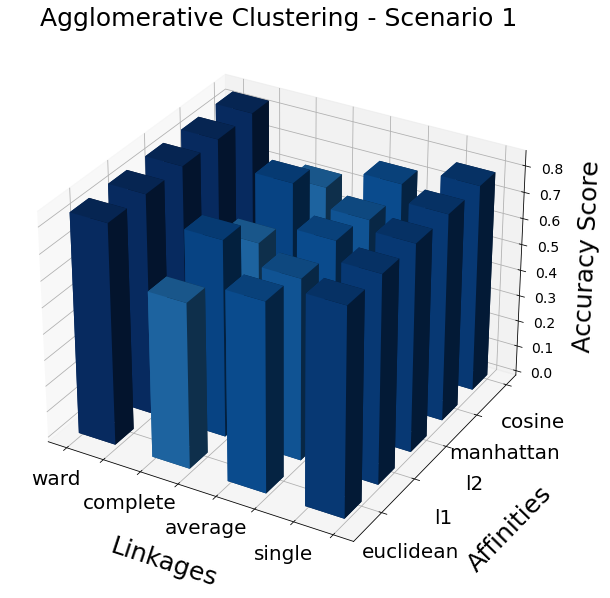

[[0.84 0.84 0.84 0.84 0.84]
 [0.63 0.75 0.63 0.75 0.63]
 [0.72 0.69 0.72 0.69 0.72]
 [0.79 0.79 0.79 0.79 0.79]]


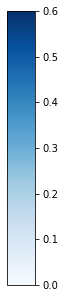

In [20]:
linkages = ['ward','complete','average','single']
affinities = ['euclidean','l1','l2','manhattan','cosine']
scores = np.ones([len(linkages),len(affinities)])

numOfCols = len(linkages)
numOfRows = len(affinities)

for i in range(len(linkages)):
    for j in range(len(affinities)):
        if linkages[i] == 'ward':
            x1y1_AC = AgglomerativeClustering(n_clusters=2,linkage='ward',affinity='euclidean')
        else:
            x1y1_AC = AgglomerativeClustering(n_clusters=2,linkage=linkages[i],affinity=affinities[j])
        x1y1_AC.fit(X1_norm, y1)

        x1y1_predict = x1y1_AC.labels_
        x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
        if x1y1_accuracy_score < 0.5:
            x1y1_accuracy_score = 1 - x1y1_accuracy_score
        scores[i,j] = x1y1_accuracy_score
        
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = scores.flatten(order='F')

linkages = ['','ward','','complete','','average','','single']
affinities = ['','euclidean','l1','l2','manhattan','cosine']

colors = plt.cm.Blues(scores.flatten(order='F')/float(scores.max()))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = "3d")
bar = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
ax.tick_params(axis='x', which='major', pad=8)
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xticklabels(linkages,size=20)
ax.set_yticklabels(affinities,size=20)
ax.zaxis.set_tick_params(labelsize=14, pad=8)

ax.set_xlabel('Linkages',size=25, labelpad=30)
ax.set_ylabel('Affinities',size=25, labelpad=45)
ax.set_zlabel('Accuracy Score',size=25, labelpad=20)
ax.set_title('Agglomerative Clustering - Scenario 1',size=25)
plt.show()

fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical')

print(scores)

C:\Users\James\AppData\Local\Temp/ipykernel_26924/113481996.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(linkages,size=20)
C:\Users\James\AppData\Local\Temp/ipykernel_26924/113481996.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(affinities,size=20)


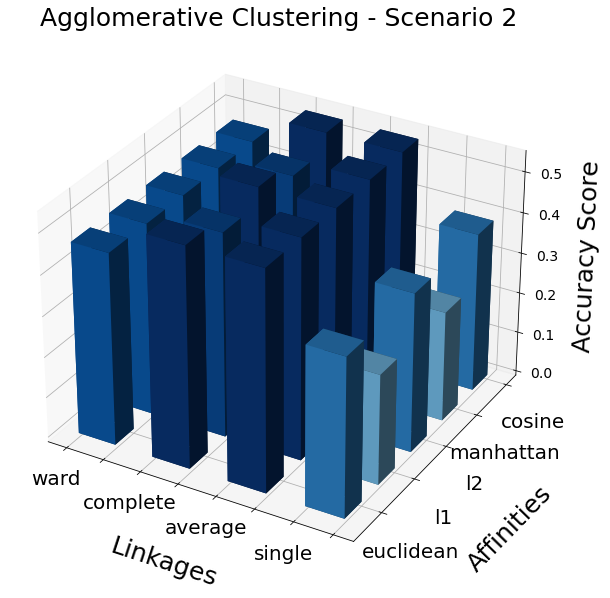

[[0.47 0.47 0.47 0.47 0.47]
 [0.54 0.5  0.54 0.5  0.54]
 [0.54 0.54 0.54 0.54 0.54]
 [0.39 0.27 0.39 0.27 0.39]]


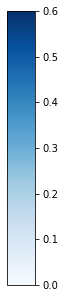

In [16]:
linkages = ['ward','complete','average','single']
affinities = ['euclidean','l1','l2','manhattan','cosine']
scores = np.ones([len(linkages),len(affinities)])

numOfCols = len(linkages)
numOfRows = len(affinities)

for i in range(len(linkages)):
    for j in range(len(affinities)):
        if linkages[i] == 'ward':
            x1y1_AC = AgglomerativeClustering(n_clusters=5,linkage='ward',affinity='euclidean')
        else:
            x1y1_AC = AgglomerativeClustering(n_clusters=5,linkage=linkages[i],affinity=affinities[j])
        x1y1_AC.fit(X3_norm)
        x1y1_predict = x1y1_AC.labels_
        
        arr = np.ones(len(x1y1_predict),dtype='int32')
        best_acc = 0
        best_f1 = 0
        best_NMI = 0

        combs = []
        arrs = np.array([0,1,2,3,4],dtype='int32')
        for comb in permutations(arrs):
            combs.append(comb)
        combs = np.array(combs)

        for combi in combs:
            for idx in range(len(x1y1_predict)):
                val = x1y1_predict[idx]
                if val == 0:
                    arr[idx] = combi[0]
                if val == 1:
                    arr[idx] = combi[1]
                if val == 2:
                    arr[idx] = combi[2]
                if val == 3:
                    arr[idx] = combi[3]
                if val == 4:
                    arr[idx] = combi[4]
            accuracy_scorei = accuracy_score(y2,arr)
            if accuracy_scorei > best_acc:
                best_acc = accuracy_scorei
                f1_scorei = f1_score(y2,arr,average='macro')
                best_f1 = f1_scorei
                NMI_score = adjusted_mutual_info_score(y2,arr)
                best_NMI = NMI_score
                best_arr = arr

        scores[i,j] = best_acc
        
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = scores.flatten(order='F')

linkages = ['','ward','','complete','','average','','single']
affinities = ['','euclidean','l1','l2','manhattan','cosine']

colors = plt.cm.Blues(scores.flatten(order='F')/float(scores.max()))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = "3d")
bar = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
ax.tick_params(axis='x', which='major', pad=8)
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xticklabels(linkages,size=20)
ax.set_yticklabels(affinities,size=20)
ax.zaxis.set_tick_params(labelsize=14, pad=8)

ax.set_xlabel('Linkages',size=25, labelpad=30)
ax.set_ylabel('Affinities',size=25, labelpad=45)
ax.set_zlabel('Accuracy Score',size=25, labelpad=20)
ax.set_title('Agglomerative Clustering - Scenario 2',size=25)
plt.show()

fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical')

print(scores)

## Z Score Scaling

In [17]:
# Scaling
scaler = StandardScaler()
X1_z = scaler.fit_transform(X1)

scaler = StandardScaler()
X2_z = scaler.fit_transform(X2)

scaler = StandardScaler()
X3_z = scaler.fit_transform(X3)

X1_z

array([[ 0.67012593, -0.27132805,  0.44190605, ..., -0.55095339,
        -0.15821528, -0.81374696],
       [-0.29537087, -0.03975012, -0.30181551, ...,  0.62188359,
         2.06303028,  0.91961545],
       [ 0.13763201,  4.40000389, -0.08244503, ..., -0.28015565,
        -0.0702055 ,  1.83211332],
       ...,
       [ 0.0497655 , -0.66250513, -1.11378927, ..., -0.30645659,
         0.61146861,  0.38324769],
       [ 0.47514195, -1.03462504,  0.15999988, ..., -0.48071808,
        -0.37171586, -0.70997241],
       [-2.1635599 ,  0.45624306, -0.62695627, ...,  0.48213521,
        -0.12119763, -0.11820015]])

In [24]:
# Situation 1
# x1 y1
x1y1_KM = KMeans(n_clusters=2, random_state=0)
x1y1_KM.fit(X1_z)

x1y1_predict = x1y1_KM.labels_
x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
x1y1_f1_score = f1_score(y1,x1y1_predict)
x1y1_NMI_score = adjusted_mutual_info_score(y1,x1y1_predict) 

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and NMI score of:",x1y1_NMI_score,"\n")

# x2 y1
x2y1_KM = KMeans(n_clusters=2, random_state=0)
x2y1_KM.fit(X2_z, y1)

x2y1_predict = x2y1_KM.labels_
x2y1_accuracy_score = accuracy_score(y1,x2y1_predict)
x2y1_f1_score = f1_score(y1,x2y1_predict)
x2y1_NMI_score = adjusted_mutual_info_score(y1,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and NMI score of:",x2y1_NMI_score,"\n")

# x3 y1
x3y1_KM = KMeans(n_clusters=2, random_state=0)
x3y1_KM.fit(X3_z, y1)

x3y1_predict = x3y1_KM.labels_
x3y1_accuracy_score = accuracy_score(y1,x3y1_predict)
x3y1_f1_score = f1_score(y1,x3y1_predict)
x3y1_NMI_score = adjusted_mutual_info_score(y1,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and NMI score of:",x3y1_NMI_score,"\n")

Predicted values using x1 and y1: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.25 and f1 score of: 0.11764705882352941 and NMI score of: 0.015827750787670992 

Predicted values using x2 and y1: [1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0
 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0
 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1

In [25]:
for idx in range(len(x1y1_predict)):
    if x1y1_predict[idx] == 0:
        x1y1_predict[idx] = 1
    elif x1y1_predict[idx] == 1:
        x1y1_predict[idx] = 0
            
x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
x1y1_f1_score = f1_score(y1,x1y1_predict)
x1y1_NMI_score = adjusted_mutual_info_score(y1,x1y1_predict) 

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and NMI score of:",x1y1_NMI_score,"\n")

for idx in range(len(x2y1_predict)):
    if x2y1_predict[idx] == 0:
        x2y1_predict[idx] = 1
    elif x2y1_predict[idx] == 1:
        x2y1_predict[idx] = 0
        
x2y1_accuracy_score = accuracy_score(y1,x2y1_predict)
x2y1_f1_score = f1_score(y1,x2y1_predict)
x2y1_NMI_score = adjusted_mutual_info_score(y1,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and NMI score of:",x2y1_NMI_score,"\n")

for idx in range(len(x3y1_predict)):
    if x3y1_predict[idx] == 0:
        x3y1_predict[idx] = 1
    elif x3y1_predict[idx] == 1:
        x3y1_predict[idx] = 0
        
x3y1_accuracy_score = accuracy_score(y1,x3y1_predict)
x3y1_f1_score = f1_score(y1,x3y1_predict)
x3y1_NMI_score = adjusted_mutual_info_score(y1,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and NMI score of:",x3y1_NMI_score,"\n")

Predicted values using x1 and y1: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.75 and f1 score of: 0.8571428571428572 and NMI score of: 0.015827750787670996 

Predicted values using x2 and y1: [0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1
 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1
 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 

In [40]:
# Situation 2
# x1 y2
x1y2_KM = AgglomerativeClustering(n_clusters=5,linkage='average',affinity='cosine')
x1y2_KM.fit(X1_z)

x1y2_predict = x1y2_KM.labels_
x1y2_accuracy_score = accuracy_score(y2,x1y2_predict)
x1y2_f1_score = f1_score(y2,x1y2_predict,average='macro')
x1y2_NMI_score = adjusted_mutual_info_score(y2,x1y2_predict) 

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and NMI score of:",x1y2_NMI_score,"\n")

# x2 y2
x2y2_KM = AgglomerativeClustering(n_clusters=5,linkage='ward',affinity='euclidean')
x2y2_KM.fit(X2_z)

x2y2_predict = x2y2_KM.labels_
x2y2_accuracy_score = accuracy_score(y2,x2y2_predict)
x2y2_f1_score = f1_score(y2,x2y2_predict,average='macro')
x2y2_NMI_score = adjusted_mutual_info_score(y2,x2y2_predict) 
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and NMI score of:",x2y2_NMI_score,"\n")

# x3 y2
x3y2_KM = AgglomerativeClustering(n_clusters=5,linkage='ward',affinity='euclidean')
x3y2_KM.fit(X3_z)

x3y2_predict = x3y2_KM.labels_
x3y2_accuracy_score = accuracy_score(y2,x3y2_predict)
x3y2_f1_score = f1_score(y2,x3y2_predict,average='macro')
x3y2_NMI_score = adjusted_mutual_info_score(y2,x3y2_predict) 

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and NMI score of:",x3y2_NMI_score,"\n")

Predicted values using x1 and y2: [4 0 1 3 4 4 2 1 0 3 4 3 1 1 0 4 2 2 3 0 4 2 1 2 3 4 2 0 3 0 4 2 1 2 0 4 2
 2 2 4 4 4 4 2 2 4 4 4 4 0 4 3 1 3 2 4 2 0 2 0 4 1 1 2 0 4 2 4 2 0 4 2 2 3
 0 4 4 3 2 0 4 4 1 1 0 4 2 1 2 0 4 4 1 3 4 4 2 1 2 2]
Expected values: [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3
 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]
Resulting in an accuracy score of: 0.13 and f1 score of: 0.13779289869160272 and NMI score of: 0.32111139779349634 

Predicted values using x2 and y2: [2 3 3 0 2 2 1 0 1 4 2 4 0 3 1 2 3 1 0 0 2 0 0 0 4 2 0 0 1 0 2 0 0 1 0 2 3
 0 1 1 2 0 0 0 1 2 0 2 0 1 2 0 1 0 1 2 0 1 0 1 2 0 0 1 0 2 3 1 1 3 2 0 1 4
 0 2 2 0 0 1 2 0 0 0 3 2 0 3 3 3 2 0 1 0 0 2 3 0 2 1]
Expected values: [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3
 4 0 1 2 3 4 0 1 2 

C:\Users\James\AppData\Local\Temp/ipykernel_19944/2961201097.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(linkages,size=20)
C:\Users\James\AppData\Local\Temp/ipykernel_19944/2961201097.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(affinities,size=20)


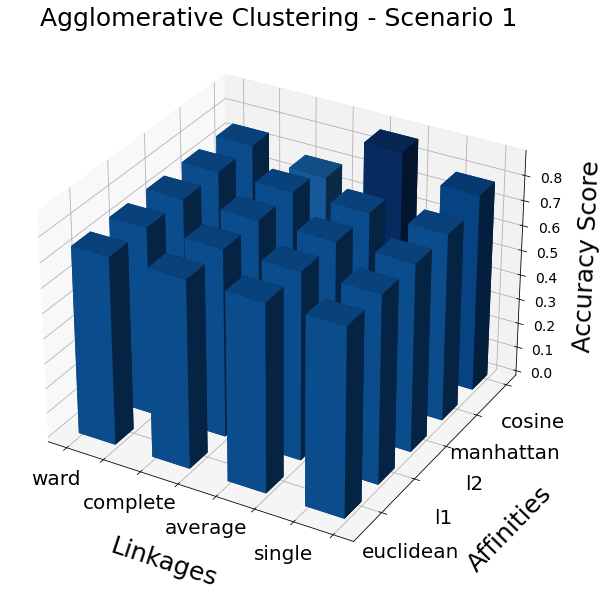

[[0.75 0.75 0.75 0.75 0.75]
 [0.75 0.75 0.75 0.75 0.7 ]
 [0.75 0.75 0.75 0.75 0.88]
 [0.75 0.75 0.75 0.75 0.79]]


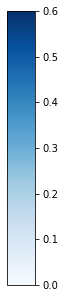

In [25]:
linkages = ['ward','complete','average','single']
affinities = ['euclidean','l1','l2','manhattan','cosine']
scores = np.ones([len(linkages),len(affinities)])

numOfCols = len(linkages)
numOfRows = len(affinities)

for i in range(len(linkages)):
    for j in range(len(affinities)):
        if linkages[i] == 'ward':
            x1y1_AC = AgglomerativeClustering(n_clusters=2,linkage='ward',affinity='euclidean')
        else:
            x1y1_AC = AgglomerativeClustering(n_clusters=2,linkage=linkages[i],affinity=affinities[j])
        x1y1_AC.fit(X1_z, y1)

        x1y1_predict = x1y1_AC.labels_
        x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
        if x1y1_accuracy_score < 0.5:
            x1y1_accuracy_score = 1 - x1y1_accuracy_score
        scores[i,j] = x1y1_accuracy_score
        
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = scores.flatten(order='F')

linkages = ['','ward','','complete','','average','','single']
affinities = ['','euclidean','l1','l2','manhattan','cosine']

colors = plt.cm.Blues(scores.flatten(order='F')/float(scores.max()))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = "3d")
bar = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
ax.tick_params(axis='x', which='major', pad=8)
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xticklabels(linkages,size=20)
ax.set_yticklabels(affinities,size=20)
ax.zaxis.set_tick_params(labelsize=14, pad=8)

ax.set_xlabel('Linkages',size=25, labelpad=30)
ax.set_ylabel('Affinities',size=25, labelpad=45)
ax.set_zlabel('Accuracy Score',size=25, labelpad=20)
ax.set_title('Agglomerative Clustering - Scenario 1',size=25)
plt.show()

fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical')

print(scores)

C:\Users\James\AppData\Local\Temp/ipykernel_26924/2989024350.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(linkages,size=20)
C:\Users\James\AppData\Local\Temp/ipykernel_26924/2989024350.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(affinities,size=20)


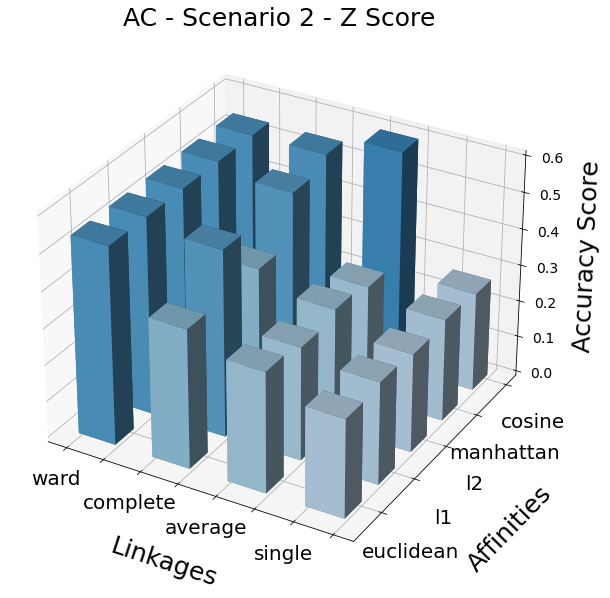

[[0.54 0.54 0.54 0.54 0.54]
 [0.38 0.51 0.38 0.51 0.54]
 [0.33 0.31 0.33 0.31 0.6 ]
 [0.27 0.28 0.27 0.28 0.27]]
[[0.51535664 0.51535664 0.51535664 0.51535664 0.51535664]
 [0.36223822 0.47547911 0.36223822 0.47547911 0.5209284 ]
 [0.29416029 0.25710438 0.29416029 0.25710438 0.58762763]
 [0.19350649 0.20748333 0.19350649 0.20748333 0.18843571]]
[[0.3635604  0.3635604  0.3635604  0.3635604  0.3635604 ]
 [0.17588262 0.24665079 0.17588262 0.24665079 0.39261565]
 [0.12262899 0.11688793 0.12262899 0.11688793 0.3211114 ]
 [0.06025557 0.07885106 0.06025557 0.07885106 0.08001629]]


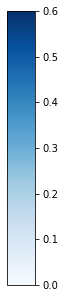

In [48]:
linkages = ['ward','complete','average','single']
affinities = ['euclidean','l1','l2','manhattan','cosine']
scores = np.ones([len(linkages),len(affinities)])
f1 = np.ones([len(linkages),len(affinities)])
NMI = np.ones([len(linkages),len(affinities)])

numOfCols = len(linkages)
numOfRows = len(affinities)

for i in range(len(linkages)):
    for j in range(len(affinities)):
        if linkages[i] == 'ward':
            x1y1_AC = AgglomerativeClustering(n_clusters=5,linkage='ward',affinity='euclidean')
        else:
            x1y1_AC = AgglomerativeClustering(n_clusters=5,linkage=linkages[i],affinity=affinities[j])
        x1y1_AC.fit(X1_z)
        x1y1_predict = x1y1_AC.labels_
        
        arr = np.ones(len(x1y1_predict),dtype='int32')
        best_acc = 0
        best_f1 = 0
        best_NMI = 0

        combs = []
        arrs = np.array([0,1,2,3,4],dtype='int32')
        for comb in permutations(arrs):
            combs.append(comb)
        combs = np.array(combs)

        for combi in combs:
            for idx in range(len(x1y1_predict)):
                val = x1y1_predict[idx]
                if val == 0:
                    arr[idx] = combi[0]
                if val == 1:
                    arr[idx] = combi[1]
                if val == 2:
                    arr[idx] = combi[2]
                if val == 3:
                    arr[idx] = combi[3]
                if val == 4:
                    arr[idx] = combi[4]
            accuracy_scorei = accuracy_score(y2,arr)
            if accuracy_scorei > best_acc:
                best_acc = accuracy_scorei
                f1_scorei = f1_score(y2,arr,average='macro')
                best_f1 = f1_scorei
                NMI_score = adjusted_mutual_info_score(y2,arr)
                best_NMI = NMI_score
                best_arr = arr
        
        scores[i,j] = best_acc
        f1[i,j] = best_f1
        NMI[i,j] = best_NMI
        
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = scores.flatten(order='F')

linkages = ['','ward','','complete','','average','','single']
affinities = ['','euclidean','l1','l2','manhattan','cosine']

colors = plt.cm.Blues(scores.flatten(order='F')/0.94)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = "3d")
bar = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
ax.tick_params(axis='x', which='major', pad=8)
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xticklabels(linkages,size=20)
ax.set_yticklabels(affinities,size=20)
ax.zaxis.set_tick_params(labelsize=14, pad=8)

ax.set_xlabel('Linkages',size=25, labelpad=30)
ax.set_ylabel('Affinities',size=25, labelpad=45)
ax.set_zlabel('Accuracy Score',size=25, labelpad=20)
ax.set_title('AC - Scenario 2 - Z Score',size=25)
plt.show()

fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical')

print(scores)
print(f1)
print(NMI)

## PCS

In [22]:
# PCA
pca = PCA()
X1_PCS = pca.fit_transform(X1)

pca = PCA()
X2_PCS = pca.fit_transform(X2)

pca = PCA()
X3_PCS = pca.fit_transform(X3)

X1_PCS

array([[-4.16614106e+01, -6.74043400e+00,  1.58274026e+00, ...,
         1.06861356e-02, -1.71307944e-02, -1.08805422e-02],
       [ 3.69255124e+01,  4.02139331e+00, -1.01372684e+01, ...,
        -3.61717723e-04, -4.74672599e-03,  2.31698356e-03],
       [ 2.80351249e+01, -1.07933579e+00, -4.54077214e+00, ...,
         1.72175728e-02,  4.59150956e-03, -1.15119667e-02],
       ...,
       [-4.34707695e-01, -5.85492465e+00, -1.53217573e+00, ...,
        -7.55354769e-04, -1.68514831e-02,  6.61002309e-05],
       [-1.82831596e+01, -8.77946777e+00, -2.48629931e+00, ...,
         1.30756617e-02,  4.06909864e-04,  1.42669777e-02],
       [ 4.51236719e+00,  2.31470291e+01,  9.28627562e+00, ...,
        -1.44242349e-02, -1.55715062e-03, -2.82138835e-03]])

In [36]:
# Situation 1
# x1 y1
x1y1_KM = AgglomerativeClustering(n_clusters=2,linkage='ward',affinity='euclidean')
x1y1_KM.fit(X1_PCS)

x1y1_predict = x1y1_KM.labels_
x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
x1y1_f1_score = f1_score(y1,x1y1_predict)
x1y1_NMI_score = adjusted_mutual_info_score(y1,x1y1_predict) 

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and NMI score of:",x1y1_NMI_score,"\n")

# x2 y1
x2y1_KM = AgglomerativeClustering(n_clusters=2,linkage='ward',affinity='euclidean')
x2y1_KM.fit(X2_PCS)

x2y1_predict = x2y1_KM.labels_
x2y1_accuracy_score = accuracy_score(y1,x2y1_predict)
x2y1_f1_score = f1_score(y1,x2y1_predict)
x2y1_NMI_score = adjusted_mutual_info_score(y1,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and NMI score of:",x2y1_NMI_score,"\n")

# x3 y1
x3y1_KM = AgglomerativeClustering(n_clusters=2,linkage='ward',affinity='euclidean')
x3y1_KM.fit(X3_PCS)

x3y1_predict = x3y1_KM.labels_
x3y1_accuracy_score = accuracy_score(y1,x3y1_predict)
x3y1_f1_score = f1_score(y1,x3y1_predict)
x3y1_NMI_score = adjusted_mutual_info_score(y1,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and NMI score of:",x3y1_NMI_score,"\n")

Predicted values using x1 and y1: [1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.16 and f1 score of: 0.2758620689655173 and NMI score of: 0.433646005015027 

Predicted values using x2 and y1: [1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1

In [37]:
for idx in range(len(x1y1_predict)):
    if x1y1_predict[idx] == 0:
        x1y1_predict[idx] = 1
    elif x1y1_predict[idx] == 1:
        x1y1_predict[idx] = 0
            
x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
x1y1_f1_score = f1_score(y1,x1y1_predict)
x1y1_NMI_score = adjusted_mutual_info_score(y1,x1y1_predict) 

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and NMI score of:",x1y1_NMI_score,"\n")

for idx in range(len(x2y1_predict)):
    if x2y1_predict[idx] == 0:
        x2y1_predict[idx] = 1
    elif x2y1_predict[idx] == 1:
        x2y1_predict[idx] = 0
        
x2y1_accuracy_score = accuracy_score(y1,x2y1_predict)
x2y1_f1_score = f1_score(y1,x2y1_predict)
x2y1_NMI_score = adjusted_mutual_info_score(y1,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and NMI score of:",x2y1_NMI_score,"\n")

for idx in range(len(x3y1_predict)):
    if x3y1_predict[idx] == 0:
        x3y1_predict[idx] = 1
    elif x3y1_predict[idx] == 1:
        x3y1_predict[idx] = 0
        
x3y1_accuracy_score = accuracy_score(y1,x3y1_predict)
x3y1_f1_score = f1_score(y1,x3y1_predict)
x3y1_NMI_score = adjusted_mutual_info_score(y1,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y1)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and NMI score of:",x3y1_NMI_score,"\n")

Predicted values using x1 and y1: [0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0
 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.84 and f1 score of: 0.888888888888889 and NMI score of: 0.433646005015027 

Predicted values using x2 and y1: [0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1]
Expected values: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 

In [29]:
# Situation 2
# x1 y2
x1y2_KM = KMeans(n_clusters=5, random_state=0)
x1y2_KM.fit(X1_PCS)

x1y2_predict = x1y2_KM.labels_
x1y2_accuracy_score = accuracy_score(y2,x1y2_predict)
x1y2_f1_score = f1_score(y2,x1y2_predict,average='macro')
x1y2_NMI_score = adjusted_mutual_info_score(y2,x1y2_predict) 

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and NMI score of:",x1y2_NMI_score,"\n")

# x2 y2
x2y2_KM = KMeans(n_clusters=5, random_state=0)
x2y2_KM.fit(X2_PCS)

x2y2_predict = x2y2_KM.labels_
x2y2_accuracy_score = accuracy_score(y2,x2y2_predict)
x2y2_f1_score = f1_score(y2,x2y2_predict,average='macro')
x2y2_NMI_score = adjusted_mutual_info_score(y2,x2y2_predict) 
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and NMI score of:",x2y2_NMI_score,"\n")

# x3 y2
x3y2_KM = KMeans(n_clusters=5, random_state=0)
x3y2_KM.fit(X3_PCS)

x3y2_predict = x3y2_KM.labels_
x3y2_accuracy_score = accuracy_score(y2,x3y2_predict)
x3y2_f1_score = f1_score(y2,x3y2_predict,average='macro')
x3y2_NMI_score = adjusted_mutual_info_score(y2,x3y2_predict) 

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y2)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and NMI score of:",x3y2_NMI_score,"\n")

Predicted values using x1 and y2: [1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0]
Expected values: [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3
 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]
Resulting in an accuracy score of: 0.07 and f1 score of: 0.05 and NMI score of: 0.24876960080665383 

Predicted values using x2 and y2: [1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0]
Expected values: [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3
 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0

C:\Users\James\AppData\Local\Temp/ipykernel_26924/1600015460.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(linkages,size=20)
C:\Users\James\AppData\Local\Temp/ipykernel_26924/1600015460.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(affinities,size=20)


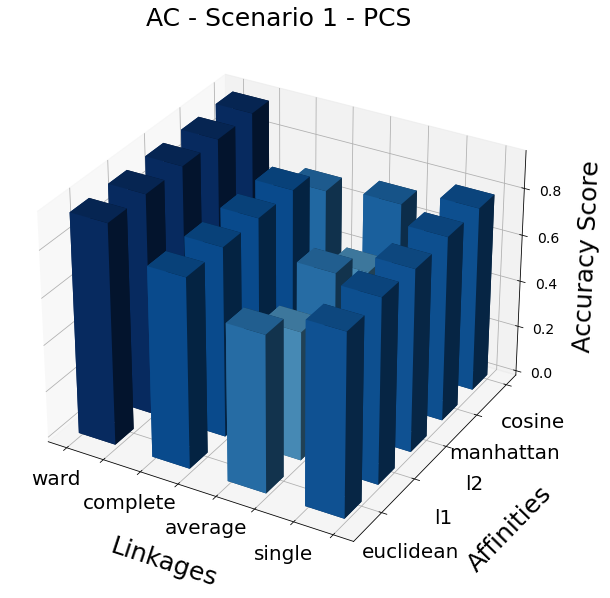

[[0.94 0.94 0.94 0.94 0.94]
 [0.81 0.81 0.81 0.81 0.69]
 [0.67 0.55 0.67 0.55 0.72]
 [0.78 0.79 0.78 0.79 0.79]]


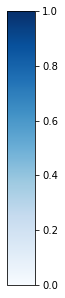

In [51]:
linkages = ['ward','complete','average','single']
affinities = ['euclidean','l1','l2','manhattan','cosine']
scores = np.ones([len(linkages),len(affinities)])

numOfCols = len(linkages)
numOfRows = len(affinities)

for i in range(len(linkages)):
    for j in range(len(affinities)):
        if linkages[i] == 'ward':
            x1y1_AC = AgglomerativeClustering(n_clusters=2,linkage='ward',affinity='euclidean')
        else:
            x1y1_AC = AgglomerativeClustering(n_clusters=2,linkage=linkages[i],affinity=affinities[j])
        x1y1_AC.fit(X2_PCS, y1)

        x1y1_predict = x1y1_AC.labels_
        x1y1_accuracy_score = accuracy_score(y1,x1y1_predict)
        if x1y1_accuracy_score < 0.5:
            x1y1_accuracy_score = 1 - x1y1_accuracy_score
        scores[i,j] = x1y1_accuracy_score
        
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = scores.flatten(order='F')

linkages = ['','ward','','complete','','average','','single']
affinities = ['','euclidean','l1','l2','manhattan','cosine']

colors = plt.cm.Blues(scores.flatten(order='F')/float(scores.max()))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = "3d")
bar = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
ax.tick_params(axis='x', which='major', pad=8)
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xticklabels(linkages,size=20)
ax.set_yticklabels(affinities,size=20)
ax.zaxis.set_tick_params(labelsize=14, pad=8)

ax.set_xlabel('Linkages',size=25, labelpad=30)
ax.set_ylabel('Affinities',size=25, labelpad=45)
ax.set_zlabel('Accuracy Score',size=25, labelpad=20)
ax.set_title('AC - Scenario 1 - PCS',size=25)
plt.show()

fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical')

print(scores)

C:\Users\James\AppData\Local\Temp/ipykernel_26924/1415786799.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(linkages,size=20)
C:\Users\James\AppData\Local\Temp/ipykernel_26924/1415786799.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(affinities,size=20)


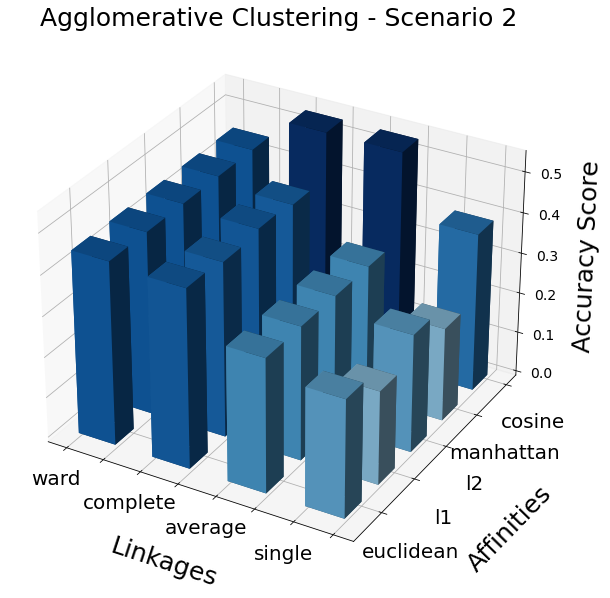

[[0.45 0.45 0.45 0.45 0.45]
 [0.44 0.43 0.44 0.43 0.54]
 [0.33 0.33 0.33 0.33 0.54]
 [0.29 0.23 0.29 0.23 0.39]]


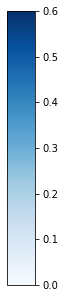

In [25]:
linkages = ['ward','complete','average','single']
affinities = ['euclidean','l1','l2','manhattan','cosine']
scores = np.ones([len(linkages),len(affinities)])

numOfCols = len(linkages)
numOfRows = len(affinities)

for i in range(len(linkages)):
    for j in range(len(affinities)):
        if linkages[i] == 'ward':
            x1y1_AC = AgglomerativeClustering(n_clusters=5,linkage='ward',affinity='euclidean')
        else:
            x1y1_AC = AgglomerativeClustering(n_clusters=5,linkage=linkages[i],affinity=affinities[j])
        x1y1_AC.fit(X3_PCS)
        x1y1_predict = x1y1_AC.labels_
        
        arr = np.ones(len(x1y1_predict),dtype='int32')
        best_acc = 0
        best_f1 = 0
        best_NMI = 0

        combs = []
        arrs = np.array([0,1,2,3,4],dtype='int32')
        for comb in permutations(arrs):
            combs.append(comb)
        combs = np.array(combs)

        for combi in combs:
            for idx in range(len(x1y1_predict)):
                val = x1y1_predict[idx]
                if val == 0:
                    arr[idx] = combi[0]
                if val == 1:
                    arr[idx] = combi[1]
                if val == 2:
                    arr[idx] = combi[2]
                if val == 3:
                    arr[idx] = combi[3]
                if val == 4:
                    arr[idx] = combi[4]
            accuracy_scorei = accuracy_score(y2,arr)
            if accuracy_scorei > best_acc:
                best_acc = accuracy_scorei
                f1_scorei = f1_score(y2,arr,average='macro')
                best_f1 = f1_scorei
                NMI_score = adjusted_mutual_info_score(y2,arr)
                best_NMI = NMI_score
                best_arr = arr

        scores[i,j] = best_acc
        
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)

dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = scores.flatten(order='F')

linkages = ['','ward','','complete','','average','','single']
affinities = ['','euclidean','l1','l2','manhattan','cosine']

colors = plt.cm.Blues(scores.flatten(order='F')/float(scores.max()))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = "3d")
bar = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)
ax.tick_params(axis='x', which='major', pad=8)
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xticklabels(linkages,size=20)
ax.set_yticklabels(affinities,size=20)
ax.zaxis.set_tick_params(labelsize=14, pad=8)

ax.set_xlabel('Linkages',size=25, labelpad=30)
ax.set_ylabel('Affinities',size=25, labelpad=45)
ax.set_zlabel('Accuracy Score',size=25, labelpad=20)
ax.set_title('Agglomerative Clustering - Scenario 2',size=25)
plt.show()

fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical')

print(scores)

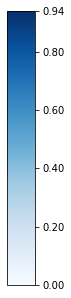

In [61]:
fig, ax = plt.subplots(figsize=(0.5, 10))
fig.subplots_adjust(bottom=0.5)

bounds = [0,0.2,0.4,0.6,0.8,0.94]
cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=0.94)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical',ticks=bounds)